<a href="https://colab.research.google.com/github/AashaiAvadhani1/MachineUnlLearning/blob/main/final_unlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Machine UnLearning


#### Based off of the NeurIPS 2023 Machine Unlearning Challenge Starting Kit

#### The unlearning algorithm was found from a paper I read which can be found on the ppt


This notebook was written in GoogleColab due to the GPU resources needed for this assignment.

This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).


  * Feature Engineering and primary ResNet18 model performance


  * 🎯 In the second section we'll develop the unlearning algorithm. This is where we will talk about the 2 types of unlearning algorithms we were able to develop


  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA).

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [197]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [198]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

Files already downloaded and verified
Files already downloaded and verified


We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [199]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

## EDA

For the EDA we show the various types of classes that we have for each image to predict the original ResNet18 model on

Files already downloaded and verified


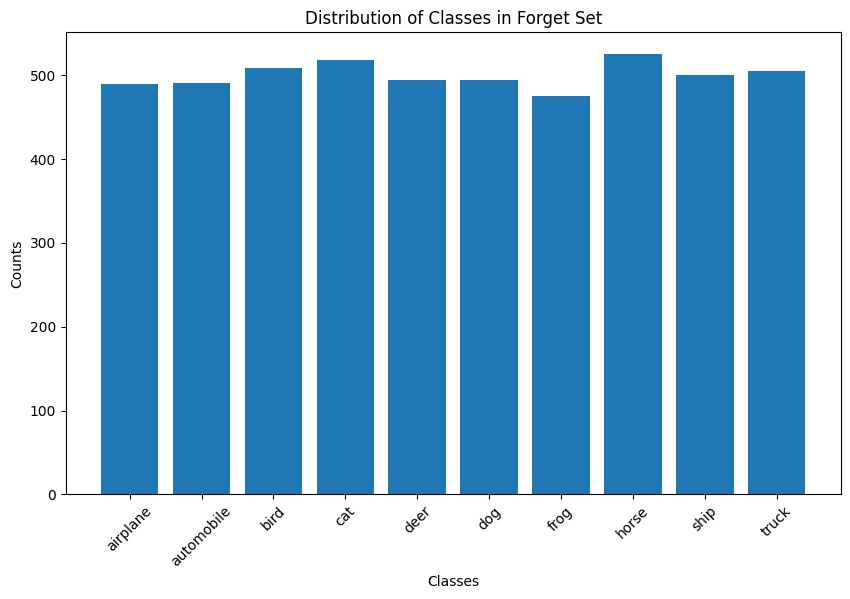

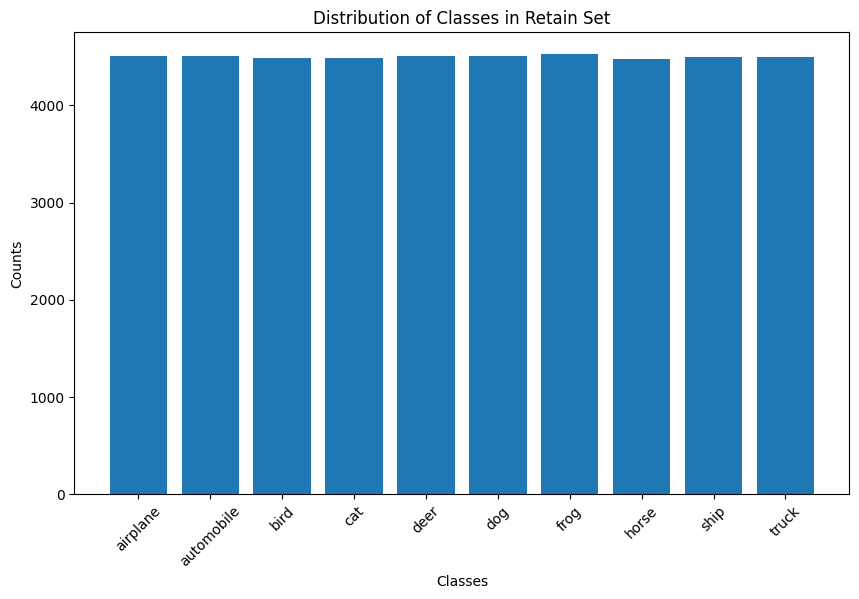

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split, Subset

RNG = torch.Generator()
RNG.manual_seed(0)

normalize = Compose([
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=normalize)

num_forget = 5000
forget_idx = np.random.choice(len(train_set), num_forget, replace=False)

forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

forget_set = Subset(train_set, forget_idx)
retain_set = Subset(train_set, retain_idx)

def analyze_dataset(dataset, title):
    labels = [dataset.dataset.targets[idx] for idx in dataset.indices]

    label_counts = np.bincount(labels, minlength=10)
    label_names = train_set.classes

    plt.figure(figsize=(10, 6))
    plt.bar(label_names, label_counts)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

analyze_dataset(forget_set, 'Distribution of Classes in Forget Set')

analyze_dataset(retain_set, 'Distribution of Classes in Retain Set')


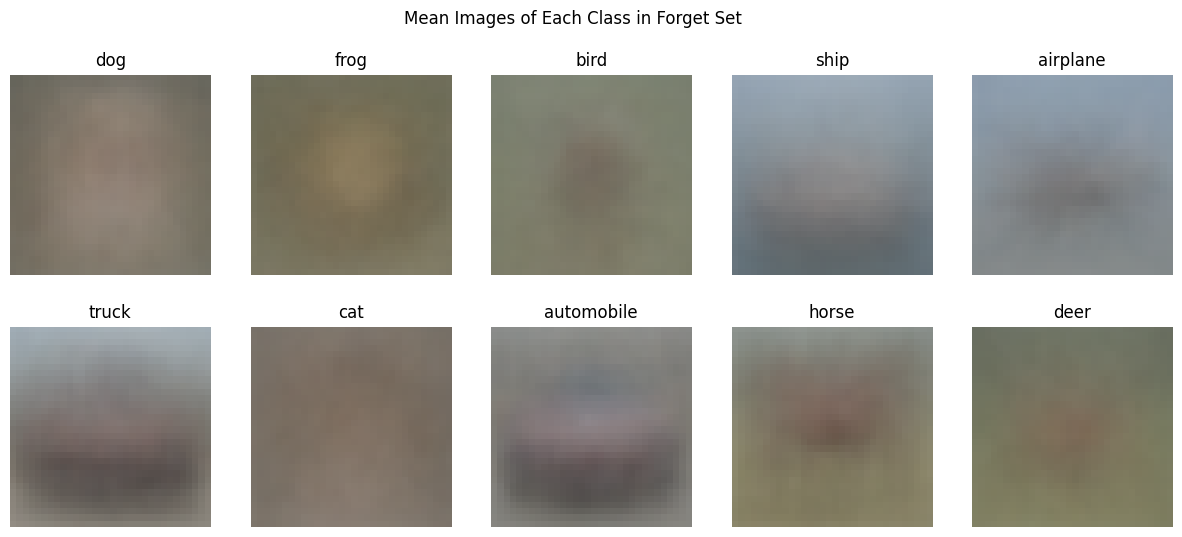

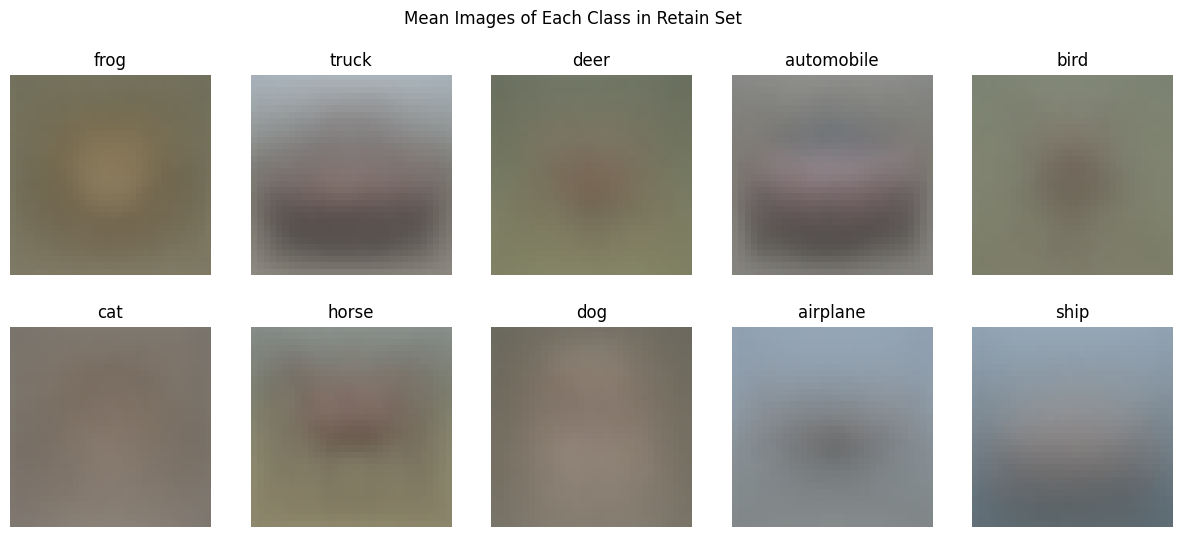

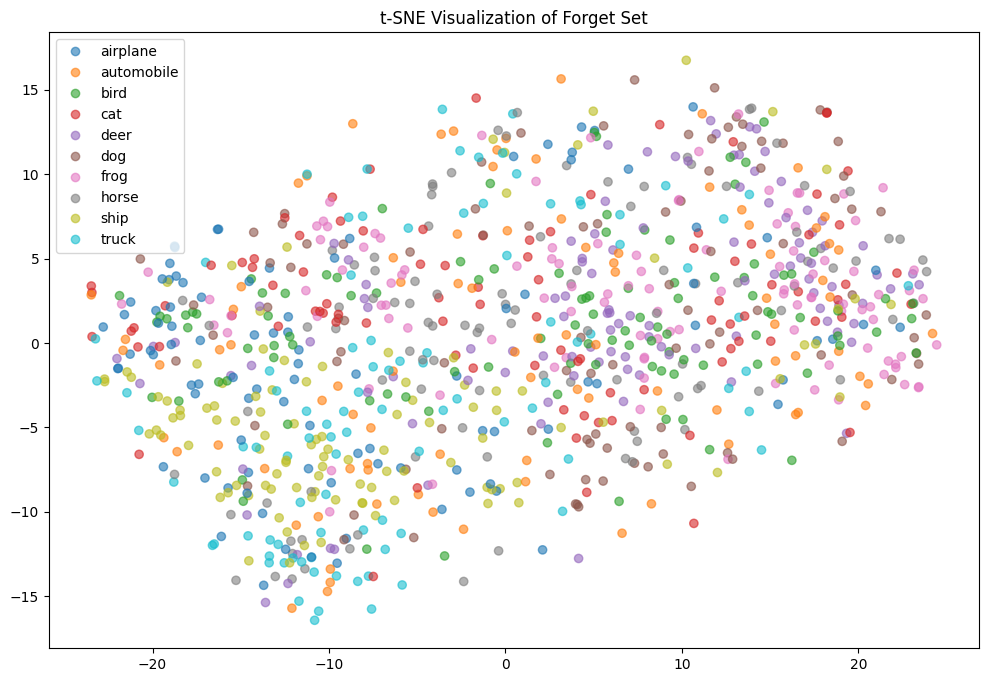

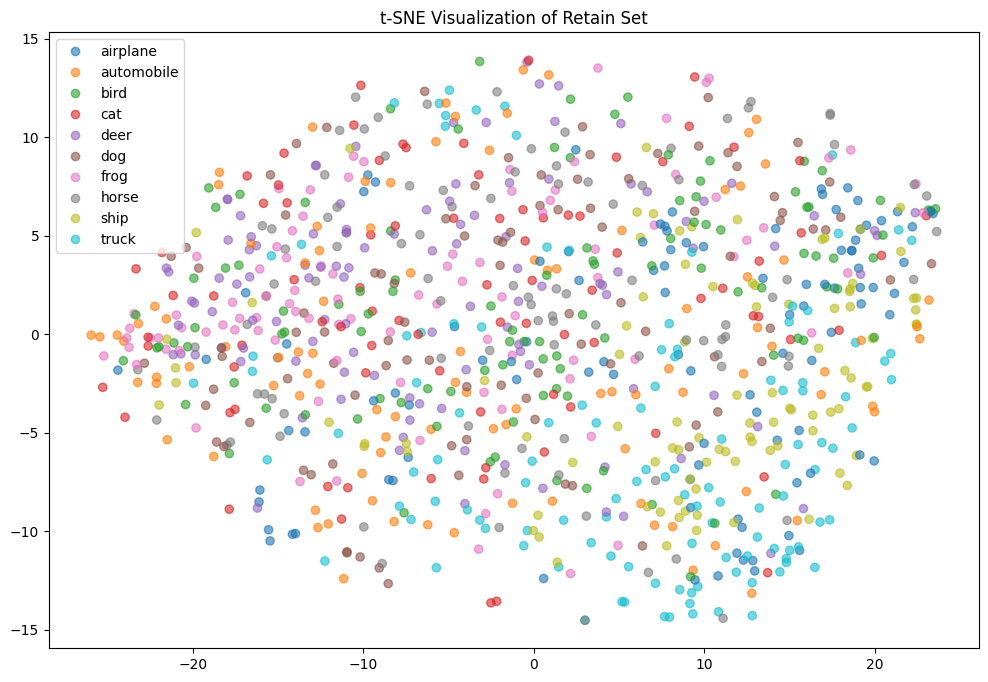

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from sklearn.manifold import TSNE

# Function to calculate the mean image for each class
def plot_mean_images(dataset, title):
    mean_images = {}
    for idx in dataset.indices:
        label = dataset.dataset.targets[idx]
        if label not in mean_images:
            mean_images[label] = []
        mean_images[label].append(dataset.dataset.data[idx])

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title)
    for i, (label, images) in enumerate(mean_images.items()):
        mean_image = np.mean(images, axis=0).astype(np.uint8)
        axs[i // 5, i % 5].imshow(mean_image)
        axs[i // 5, i % 5].set_title(dataset.dataset.classes[label])
        axs[i // 5, i % 5].axis('off')
    plt.show()

plot_mean_images(forget_set, 'Mean Images of Each Class in Forget Set')
plot_mean_images(retain_set, 'Mean Images of Each Class in Retain Set')

def plot_tsne(dataset, title, num_samples=1000):
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images = np.array([dataset.dataset.data[i] for i in indices])
    labels = np.array([dataset.dataset.targets[i] for i in indices])

    images_flat = images.reshape(num_samples, -1)
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(images_flat)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=dataset.dataset.classes)
    plt.title(title)
    plt.show()

plot_tsne(forget_set, 't-SNE Visualization of Forget Set')
plot_tsne(retain_set, 't-SNE Visualization of Retain Set')


The T-SNE shows how the train set has a more uneven distribution dataset while the retain set has an equal amount of data per class.

But we actually see that the mean image is actually very blurry. This means that the original ResNet pretrained model might be prone to training on noise. We do not want that otherwise the unlearning algorithm will be only used from noisy data.


## Feature Engineering

The main point of this feature engineering task is to clean the images from above to ensure the images are not blurry for the mean point.

For the feature engineering here, we can load the data and transform it based on the batch size and output the samples too

Files already downloaded and verified


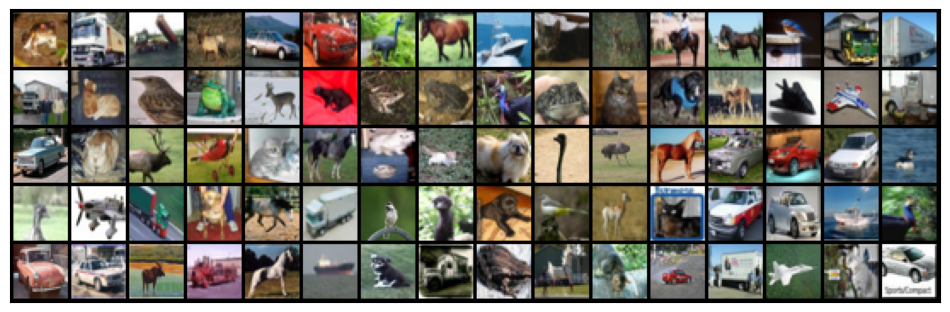

In [202]:
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

We'll now compute the model's accuracy on the train and test set.


## First Model


Prior to the unlearning algorithm, we see how the ResNet model performs on the Cifar10 dataset to create baseline metrics.

In [203]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


The base line metrics are very strong, it shows a extremly high training set (overfitting evidence) and a high test accuracy.


In the rest of the notebook, we will try different approaches to see how we can develop an unlearning algorithm that can maximize accuracy yet use less data.

# 🎯 Unlearning Algorithms

In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.


#### 1. Dummy Label

For the first unlearning algorithm, we tried a 2 step approach
We would first


In [204]:

#Evaluation function for the loss and accuracy
def evaluation(net, dataloader, criterion, device = 'cuda'): ##evaluation function
    net.eval()
    total_samp = 0
    total_acc = 0
    total_loss = 0.0
    for images, labels in dataloader:
      images, labels = images.to(DEVICE), labels.to(DEVICE)
      #images, labels = sample['image'].to(device), sample['age_group'].to(device)
      _pred = net(images)
      total_samp+=len(labels)
      #print(f'total_samp={total_samp}')
      loss = criterion(_pred, labels)
      total_loss += loss.item()
      total_acc+=(_pred.max(1)[1] == labels).float().sum().item()
        #print(f'total_acc={total_acc}')
    #print(f'total_sample={total_samp}')
    mean_loss = total_loss / len(dataloader)
    mean_acc = total_acc/total_samp
    print(f'loss={mean_loss}')
    print(f'acc={mean_acc}')
    return

In [205]:
USE_MOCK = True
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
def kl_loss_sym(x,y):
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    return kl_loss(nn.LogSoftmax(dim=-1)(x),y)



"""
Dummy Inference layer


"""
def unlearning_dummy_label(
        net,
        retain_loader,
        forget_loader,
        val_loader,
):
    """Simple unlearning by finetuning."""
    print('-----------------------------------')
    epochs = 8
    retain_bs = 256
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005,
                          momentum=0.9, weight_decay=0)
    optimizer_retain = optim.SGD(net.parameters(), lr=0.001*retain_bs/64, momentum=0.9, weight_decay=1e-2)
    ##the learning rate is associated with the batchsize we used
    optimizer_forget = optim.SGD(net.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)
    total_step = int(len(forget_loader)*epochs)
    retain_ld = DataLoader(retain_loader.dataset, batch_size=retain_bs, shuffle=True)
    retain_ld4fgt = DataLoader(retain_loader.dataset, batch_size=256, shuffle=True)
    scheduler = CosineAnnealingLR(optimizer_forget, T_max=total_step, eta_min=1e-6)
    if USE_MOCK: ##Use some Local Metric as reference
        net.eval()
        print('Forget')
        evaluation(net, forget_loader, criterion)
        print('Valid')
        evaluation(net, val_loader, criterion)
    net.train()

    #Inference from the forget dataset
    for inputs, outputs_meow in forget_loader: ##First Stage
        #inputs = sample["image"]
        #print(type(inputs))
        inputs = inputs.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        uniform_label = torch.ones_like(outputs).to(DEVICE) / outputs.shape[1] ##uniform pseudo label
        loss = kl_loss_sym(outputs, uniform_label) ##optimize the distance between logits and pseudo labels
        loss.backward()
        optimizer.step()
    if USE_MOCK:
        print('Forget')
        evaluation(net,forget_loader,criterion)
        print('Valid')
        evaluation(net, val_loader,criterion)
        print(f'epoch={epochs} and retain batch_sz={retain_bs}')
    net.train()
    #retraain the weights based on the previous optimizer
    for ep in range(epochs): ##Second Stage
        net.train()
        for sample_forget, sample_retain in zip(forget_loader, retain_ld4fgt):##Forget Round
          t = 1.15 ##temperature coefficient
          inputs_forget, inputs_retain = sample_forget[0].to(DEVICE), sample_retain[0].to(DEVICE)
          optimizer_forget.zero_grad()
          outputs_forget,outputs_retain = net(inputs_forget),net(inputs_retain).detach()
          loss = (-1 * nn.LogSoftmax(dim=-1)(outputs_forget @ outputs_retain.T/t)).mean() ##Contrastive Learning loss
          loss.backward()
          optimizer_forget.step()
          scheduler.step()

        if USE_MOCK:
          print(f'epoch {ep}:')
          print('Retain')
          evaluation(net, retain_ld, criterion)
          print('Forget')
          evaluation(net, forget_loader, criterion)
          print('Valid')
          evaluation(net, val_loader, criterion)
    print('-----------------------------------')
    return net

In [206]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning_dummy_label(ft_model, retain_loader, forget_loader, test_loader)

-----------------------------------
Forget
loss=0.021299936980358324
acc=0.9932
Valid
loss=0.4423425294458866
acc=0.8834
Forget
loss=2.634953773021698
acc=0.1444
Valid
loss=2.6581464052200316
acc=0.1494
epoch=8 and retain batch_sz=256
epoch 0:
Retain
loss=2.227228191765872
acc=0.17775555555555556
Forget
loss=2.2260857939720156
acc=0.1806
Valid
loss=2.231247341632843
acc=0.1842
epoch 1:
Retain
loss=2.235067918896675
acc=0.16991111111111112
Forget
loss=2.2409554004669188
acc=0.1712
Valid
loss=2.2406234800815583
acc=0.1698
epoch 2:
Retain
loss=2.2382732155648144
acc=0.15875555555555557
Forget
loss=2.244986617565155
acc=0.1556
Valid
loss=2.2426297664642334
acc=0.1578
epoch 3:
Retain
loss=2.2319117838686164
acc=0.16284444444444446
Forget
loss=2.237315136194229
acc=0.159
Valid
loss=2.2377943277359007
acc=0.1622
epoch 4:
Retain
loss=2.232743733308532
acc=0.16482222222222223
Forget
loss=2.2333837509155274
acc=0.1616
Valid
loss=2.2383789300918577
acc=0.1652
epoch 5:
Retain
loss=2.23398923602971


To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [207]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 16.5%
Test set accuracy: 16.7%


So we see here that the retain set and the test set has a poor accuracy rate
The retain test set is supposed to be the dataset without the "deleted" data. This means that even with the unlearning algorithm layered, the inference from the forget dataset does not work

If the inference from the retain dataset is so low, even with the retain set steps, we would not able to capitlize on this approach.

### 2. CNN Pruning

The next approach that we took was CNN pruning. Each deep learning model has a pruning methodolgy that we can use isolate and remove neurons that are not predicting other. In the CNN criteria, we can use L1 regularization for the CNN model in order to remove the neurons in the fully connected layer within Resnet18.

In [208]:
from copy import deepcopy
import torch.nn.utils.prune as prune
from math import sqrt
import torch.nn.functional as F

def kl_loss_fn(outputs, dist_target):
    kl_loss = F.kl_div(torch.log_softmax(outputs, dim=1), dist_target, log_target=True, reduction='batchmean')
    return kl_loss

def entropy_loss_fn(outputs, labels, dist_target, class_weights):
    ce_loss = F.cross_entropy(outputs, labels, weight=class_weights)
    entropy_dist_target = torch.sum(-torch.exp(dist_target) * dist_target, dim=1)
    entropy_outputs = torch.sum(-torch.softmax(outputs, dim=1) * torch.log_softmax(outputs, dim=1), dim=1)
    entropy_loss = F.mse_loss(entropy_outputs, entropy_dist_target)
    return ce_loss + entropy_loss

In [209]:
"""

Unlearning by pruning. Objective: find the neurons in the FCL to prune out
From Prasand Paper
"""
def unlearn_prune(
    net,
    retain_loader,
    forget_loader,
    val_loader,
    class_weights=None,
):
    """Simple unlearning by finetuning.
      F"""
    epochs = 3.2
    max_iters = int(len(retain_loader) * epochs)
    optimizer = optim.SGD(net.parameters(), lr=0.0005,
                      momentum=0.9, weight_decay=5e-4)
    initial_net = deepcopy(net)

    net.train()
    initial_net.eval()

    def prune_model(net, amount=0.95, rand_init=True):
      # Modules to prune
      modules = list()
      for k, m in enumerate(net.modules()):
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              modules.append((m, 'weight'))
              if m.bias is not None:
                  modules.append((m, 'bias'))

      # Prune criteria using L1 regularization for each step
      # L1 Regularization
      prune.global_unstructured(
          modules,
          #pruning_method=prune.RandomUnstructured,
          pruning_method=prune.L1Unstructured,
          amount=amount,
      )

      # Perform the prune
      for k, m in enumerate(net.modules()):
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              prune.remove(m, 'weight')
              if m.bias is not None:
                  prune.remove(m, 'bias')

      # Random initialization
      if rand_init:
          for k, m in enumerate(net.modules()):
              if isinstance(m, nn.Conv2d):
                  mask = m.weight == 0
                  c_in = mask.shape[1]
                  k = 1/(c_in*mask.shape[2]*mask.shape[3])
                  randinit = (torch.rand_like(m.weight)-0.5)*2*sqrt(k)
                  m.weight.data[mask] = randinit[mask]
              if isinstance(m, nn.Linear):
                  mask = m.weight == 0
                  c_in = mask.shape[1]
                  k = 1/c_in
                  randinit = (torch.rand_like(m.weight)-0.5)*2*sqrt(k)
                  m.weight.data[mask] = randinit[mask]

    num_iters = 0
    running = True
    prune_amount = 0.99
    prune_model(net, prune_amount, True)
    while running:
        net.train()
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Get target distribution
            with torch.no_grad():
                original_outputs = initial_net(inputs)
                preds = torch.log_softmax(original_outputs, dim=1)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = entropy_loss_fn(outputs, targets, preds, class_weights)
            loss.backward()
            optimizer.step()

            num_iters += 1
            # Stop at max iters
            if num_iters > max_iters:
                running = False
                break

    net.eval()
    return net

In [210]:
ft_model_prune = resnet18(weights=None, num_classes=10)
ft_model_prune.load_state_dict(weights_pretrained)
ft_model_prune.to(DEVICE)

ft_model_prune = unlearn_prune(ft_model_prune, retain_loader, forget_loader, test_loader)

In [211]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model_prune, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model_prune, test_loader):0.1f}%")

Retain set accuracy: 93.4%
Test set accuracy: 82.9%


# Evaluation Through MIA Scores

This evaluation piece will help us identify the whether the Resnet18 model was trained on a particular datapoint from that samples loss. If the MIA algorithm is predicting at random, then it it shows that our models will be indistringuishable from a model that was trained without the "deleted" data.



**Got this evaluation from the Google Neurips Challenge**

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss.



In this plot we actually want to see the loss performance of the model on the original train and test dataset.

In [212]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

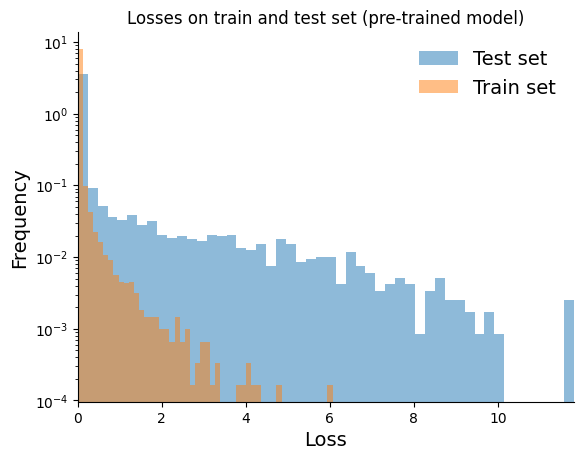

In [213]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

The plot shows the distribution of the loss function and the test set loss is relatively consistent while the train loss goes down alot.
The Membership Inference Attack will determine whether the model used the "deleted" data and predicts on the train or test loss.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set);

In [214]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [215]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.578 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [216]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [217]:
# PRUNING MODEL LOSS CHECK

ft_forget_losses_prune = compute_losses(ft_model_prune, forget_loader)
ft_test_losses_prune = compute_losses(ft_model_prune, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses_prune)

ft_samples_mia_prune = np.concatenate((ft_test_losses_prune, ft_test_losses_prune)).reshape((-1, 1))
labels_mia_prune = [0] * len(ft_test_losses_prune) + [1] * len(ft_forget_losses_prune)

In [218]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.489 on forgotten vs unseen images


In [219]:
ft_mia_scores_prune = simple_mia(ft_samples_mia_prune, labels_mia_prune)

print(
    f"The Prune MIA has an accuracy of {ft_mia_scores_prune.mean():.3f} on forgotten vs unseen images"
)

The Prune MIA has an accuracy of 0.492 on forgotten vs unseen images


We can see here that the MIA score is closer to 0.50 for the two approaches. The dummy labels had a near approach to 0.50 while pruning was off by 0.007 compared to 0.004 from dummy labels

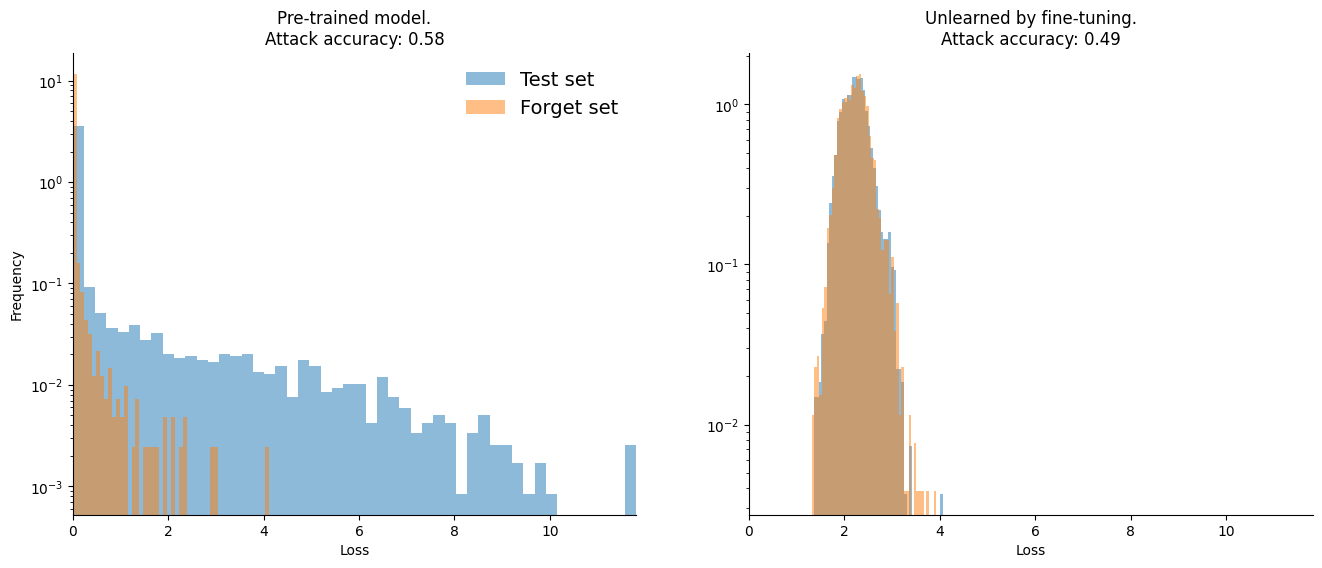

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Evaluation on The Retain Set

The Evaluation above was purely on the forget and train samples. But it would be great to get an evaluation of the MIA scores on the retain sets. This set would be the images that are not deleted from the user dataset.

Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

In [221]:
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


This is the accuracy for the pretrained model on the retain and forget set

The retain set accuracy for the Pruning Model

In [222]:

print(f"Retain set accuracy: {100.0 * accuracy(ft_model_prune, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model_prune, forget_loader):0.1f}%")

Retain set accuracy: 93.4%
Forget set accuracy: 86.0%


The retain accuracy for the dummy label model

In [223]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.1f}%")

Retain set accuracy: 16.5%
Forget set accuracy: 16.6%


As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set. The pruning and the dummy label model had a poor performance for the retain set

In [224]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [225]:
rt_test_losses_prune = compute_losses(ft_model_prune, test_loader)
rt_forget_losses_prune = compute_losses(ft_model_prune, forget_loader)

rt_samples_mia_prune = np.concatenate((rt_test_losses_prune, rt_forget_losses_prune)).reshape((-1, 1))
labels_mia_prune = [0] * len(rt_test_losses_prune) + [1] * len(rt_forget_losses_prune)

In [226]:
ft_test_losses = compute_losses(ft_model, test_loader)
ft_forget_losses = compute_losses(ft_model, forget_loader)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia_ft = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [227]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.501 on forgotten vs unseen images


In [228]:
rt_mia_scores_prune = simple_mia(rt_samples_mia_prune, labels_mia_prune)

print(
    f"The MIA has an accuracy of {rt_mia_scores_prune.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.519 on forgotten vs unseen images


In [229]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia_ft)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.489 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. But for each particular unlearning algorithm, we actually see that the mia score varies.

On the retain set, that means the dummy label actually had a better performance than the pruning algorithm.

Given though that the pruning algorithm still had a high accuracy on the retain set, it is still better to use the pruning algorithm.

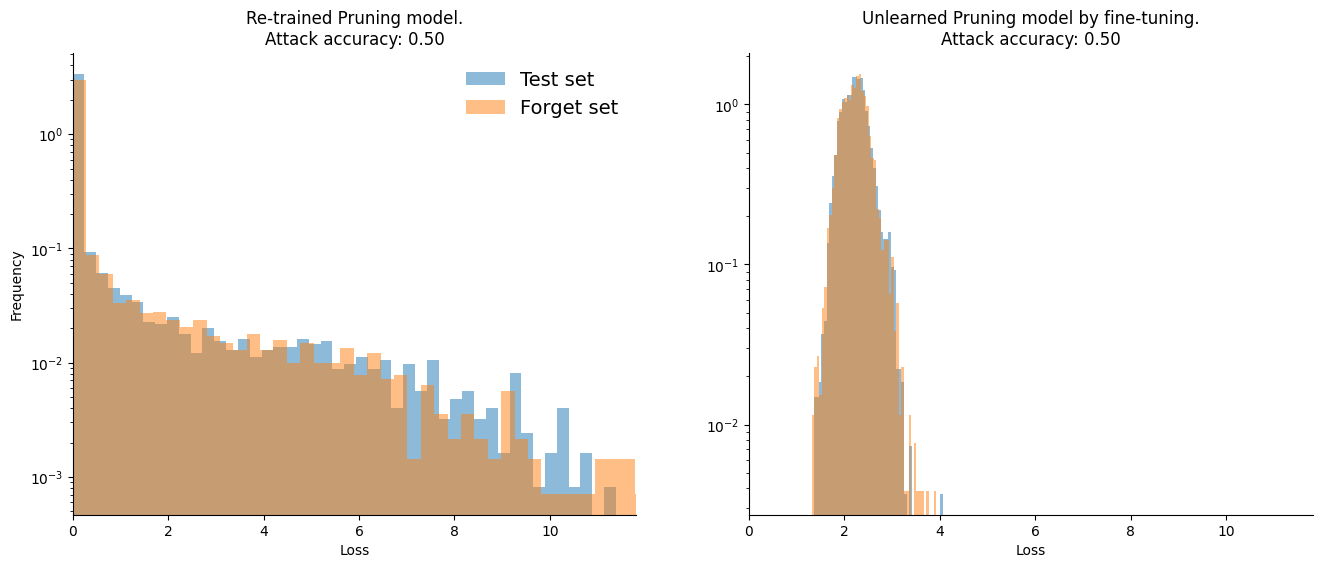

In [230]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained Pruning model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned Pruning model by fine-tuning.\nAttack accuracy: {rt_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

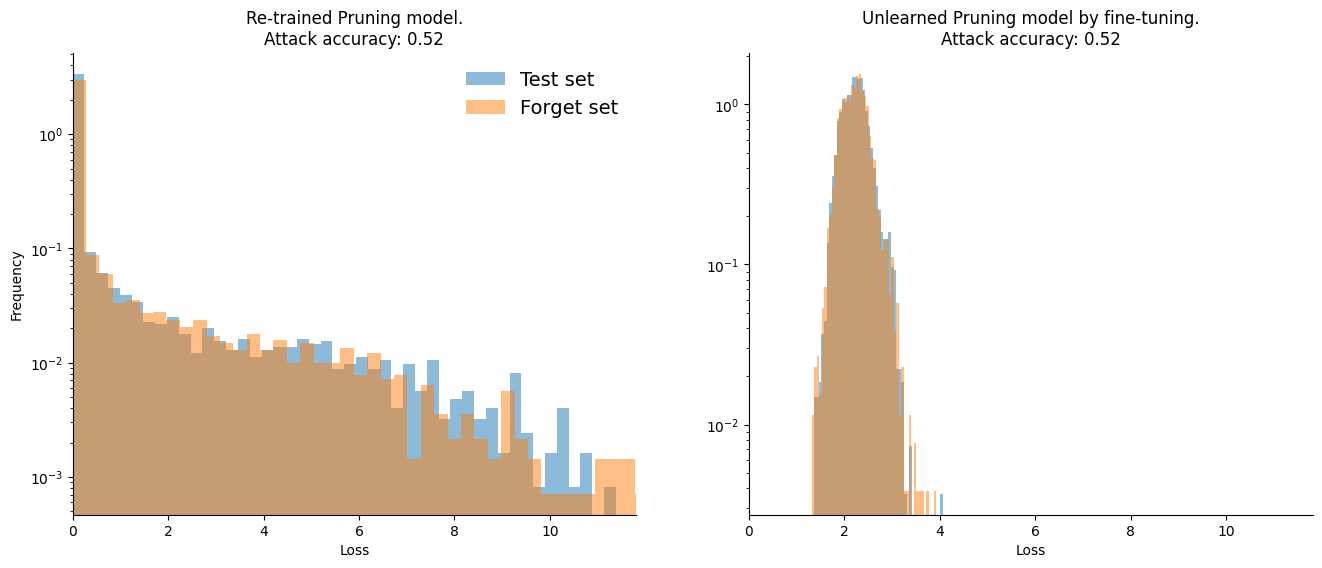

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained Pruning model.\nAttack accuracy: {rt_mia_scores_prune.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned Pruning model by fine-tuning.\nAttack accuracy: {rt_mia_scores_prune.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

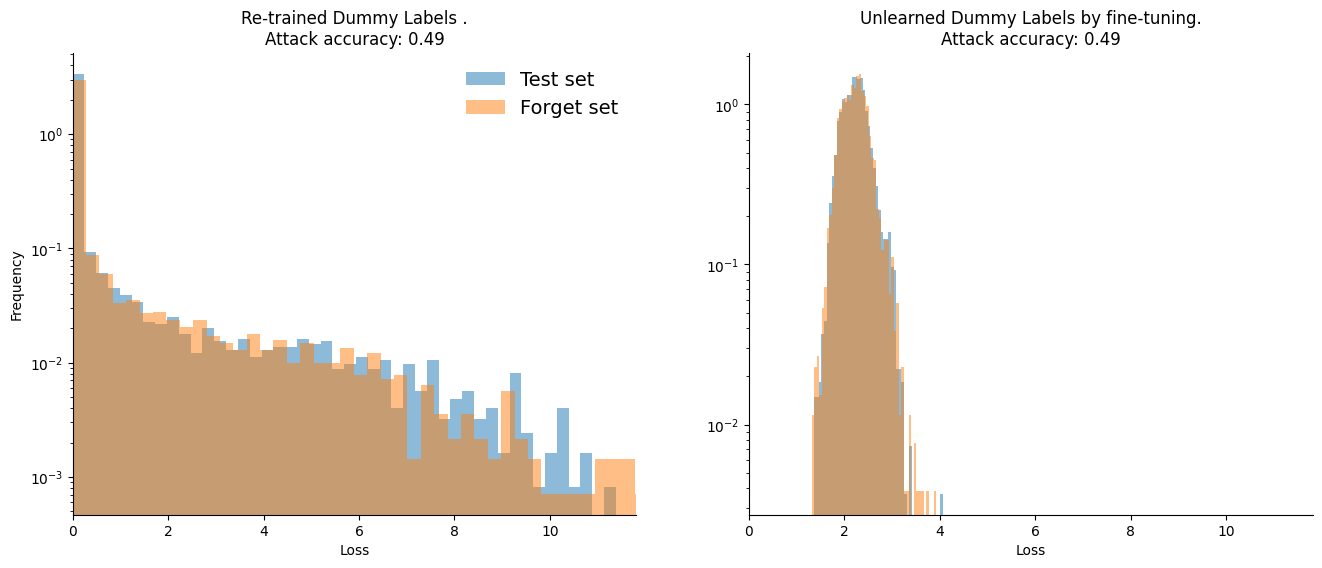

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained Dummy Labels .\nAttack accuracy: {ft_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned Dummy Labels by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

Each of the loss functions have a weird behavior on the right. The losses started at 0.

More investigation needs to be done for the MIA score for the retain set

## Conclusion


We see that there are multiple unlearning ways to implement for deep learning models. There were 2 unlearning ways that we implemented. First was the pruning methodology for CNNs which held the accuracy for the retain and test set but had a higher MIA score. That means the MIA score is slightly less reliable for predicting samples from the retain and train test.

  The second unlearning way was simply using an SGD optimizer and then adding "noise" to the data to compensate for the loss data. This performed alot worse on the accuracy but better on the MIA. That means this approach may not be that scalable since the accuracy for the retain set was not accurate.